# **Hybrid Recommender system**

For creating personalised item recommendations for users, the hybrid recommender system combines collaborative filtering (matrix factorization) with content-based filtering (item characteristics).

**How the hybrid recommender system works**

1- **Collaborative Filtering** : matrix factorization is utilised for learn deep representations (embeddings) for users and items , By factoring the user-item interaction matrix, the user and item embeddings are learned.

2- **Content-Based Filtering** : The model captures item content information using item attributes, which are represented as the item_attributes_matrix.

3- **Hybrid Score** : combine Collaborative Filtering with Content-Based Filtering for calculating hybrid recommendation score

4- Training and Evalution

***Note*** : The hybrid recommender system uses both user-item interactions and item characteristics to give personalised and accurate recommendations by combining collaborative filtering and content-based filtering.

**Import the required libraries**

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


**Main Points**

1- determines the number of unique users and items in the interactions DataFrame to determine the  dimensions of the user-item interaction matrix and get the number of attribute for each item , and convert the data to numerical

2- splits the data into training and test sets using train_test_split , The training data is further filtered to only include item IDs from the mapping dictionary.

3- creates a DataLoader to deal with data as batches

4-combines matrix factorization and content-based filtering is represented by the HybridRecommender class.

5- The architecture of the model consists of embedding layers for users and items (matrix factorization) as well as a content-based filtering module for item attributes.

**Training**

1- The Mean Squared Error (MSE) loss is used as the optimisation criterion during model training.

2- using AdAM optimizer to update the model's parameters during training

3- use the number of epochs to learn the embeddings and the parameters for the content-based filtering.

**Evalution**


1- The model's predictions are compared to the actual user-item interactions from the test data to compute the Mean Squared Error (MSE).

2- calculates three evaluation metrics: accuracy, recall, and precision

Epoch 1/10, Average Loss: 12.5037
Epoch 2/10, Average Loss: 3.1441
Epoch 3/10, Average Loss: 1.6335
Epoch 4/10, Average Loss: 1.6830
Epoch 5/10, Average Loss: 1.9404
Epoch 6/10, Average Loss: 1.6552
Epoch 7/10, Average Loss: 1.3285
Epoch 8/10, Average Loss: 1.1627
Epoch 9/10, Average Loss: 1.0773
Epoch 10/10, Average Loss: 0.9821


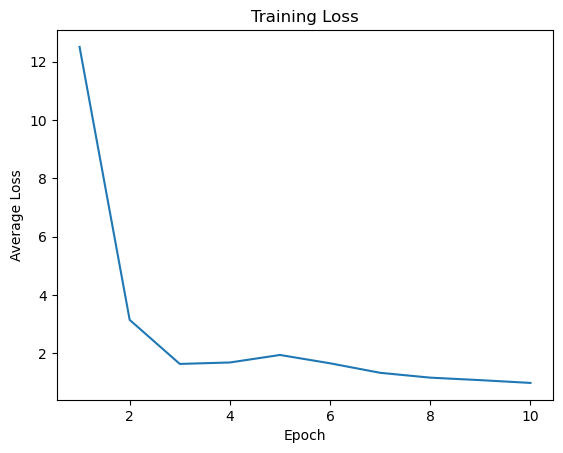

In [2]:
# Sample item attributes matrix (for illustration purposes)
item_attributes_matrix = torch.randn(30, 10)  # 30 items, 10 attributes

# Sample user-item interaction data (for illustration purposes)
# Replace 'your_table.csv' with the actual file name or path of your data
# Assuming the table has 'user_id', 'item_id', and 'click' columns
interactions_df = pd.read_csv('/kaggle/input/cold-data-07csv/cold_data_0.7.csv').head(200000)
interactions_df.drop_duplicates(subset=['user_id', 'item_id'], keep='first', inplace=True)

# For example, if you want to sum the 'click' values for duplicate user-item pairs
interactions_df = interactions_df.groupby(['user_id', 'item_id']).agg({'click': 'sum'}).reset_index()

# Create the interaction matrix (using 'click' as the rating proxy)
interaction_matrix = interactions_df.pivot_table(index='user_id', columns='item_id', values='click', fill_value=0)
interaction_matrix = interaction_matrix.fillna(0).values

# Create a mapping dictionary for item_ids to indices
item_id_to_index = {item_id: idx for idx, item_id in enumerate(interactions_df['item_id'].unique())}

# Set hyperparameters
num_users = interactions_df['user_id'].nunique()
num_items = interactions_df['item_id'].nunique()
num_attributes = item_attributes_matrix.shape[1]
embedding_dim = 16
learning_rate = 0.01
num_epochs = 10
batch_size = 32

# Convert user and item IDs to numerical labels using LabelEncoder
user_encoder = LabelEncoder()
interactions_df['user_id'] = user_encoder.fit_transform(interactions_df['user_id'])
item_encoder = LabelEncoder()
interactions_df['item_id'] = item_encoder.fit_transform(interactions_df['item_id'])

# Split the data into train and test sets
train_data, test_data = train_test_split(interactions_df, test_size=0.2, random_state=42)

# Filter train data to include only the item_ids present in the mapping dictionary
train_data = train_data[train_data['item_id'].isin(item_id_to_index)]

# Create DataLoader for training data
X_train_users = torch.tensor(train_data['user_id'].values, dtype=torch.long)
X_train_items = torch.tensor(train_data['item_id'].values, dtype=torch.long)

# Map the item IDs to their respective indices
X_train_indices = train_data['item_id'].map(item_id_to_index)
X_train_indices = X_train_indices.values

# Check if any indices are out of bounds for item_attributes_matrix
if (X_train_indices >= item_attributes_matrix.shape[0]).any():
    num_missing_items = (X_train_indices >= item_attributes_matrix.shape[0]).sum()
    item_attributes_matrix = torch.cat(
        [item_attributes_matrix, torch.zeros(num_missing_items, num_attributes)],
        dim=0
    )

# Indexing into item_attributes_matrix using the mapped indices
X_train_attributes = item_attributes_matrix[X_train_indices]

train_dataset = TensorDataset(X_train_users, X_train_items, X_train_attributes)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Instantiate the hybrid recommender model
class HybridRecommender(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim, num_attributes):
        super(HybridRecommender, self).__init__()
        # Matrix factorization for user and item embeddings
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.item_embedding = nn.Embedding(num_items, embedding_dim)
        # Content-based filtering module for item attributes
        self.content_module = nn.Sequential(
            nn.Linear(num_attributes, 32),  # Adjust hidden layers as needed
            nn.ReLU(),
            nn.Linear(32, embedding_dim)
        )

    def forward(self, user_ids, item_ids, item_attributes):
        # Matrix factorization embeddings
        user_embeds = self.user_embedding(user_ids)
        item_embeds = self.item_embedding(item_ids)
        # Content-based filtering embeddings
        item_content_embeds = self.content_module(item_attributes)

        # Combine matrix factorization and content-based embeddings
        user_item_interaction = torch.sum(user_embeds * item_embeds, dim=1)
        user_item_content_interaction = torch.sum(user_embeds * item_content_embeds, dim=1)

        # Hybrid recommendation score
        hybrid_score = user_item_interaction + user_item_content_interaction
        return hybrid_score

# Instantiate the hybrid recommender model
model = HybridRecommender(num_users, num_items, embedding_dim, num_attributes)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
losses = []
for epoch in range(num_epochs):
    total_loss = 0.0
    model.train()

    for user_ids, item_ids, item_attributes in train_loader:
        optimizer.zero_grad()
        hybrid_scores = model(user_ids, item_ids, item_attributes)
        targets = torch.tensor(interaction_matrix[user_ids, item_ids], dtype=torch.float)
        loss = criterion(hybrid_scores, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    losses.append(avg_loss)  # Store the loss value for this epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")

# Plot the loss values
plt.plot(range(1, num_epochs + 1), losses)
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Training Loss')
plt.show()

**Result on Train**

I notice that the model during training process learn well , because of the loss decrease over epoches

In [4]:
# Evaluation
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score
model.eval()
with torch.no_grad():
    test_users = torch.tensor(test_data['user_id'].values, dtype=torch.long)

    # Map test item IDs to their respective indices
    test_items = test_data['item_id'].map(item_id_to_index)

    # Filter out invalid test items with out-of-bounds indices
    valid_mask = (test_items >= 0) & (test_items < item_attributes_matrix.shape[0])
    valid_indices = torch.nonzero(torch.tensor(valid_mask.values), as_tuple=False).squeeze()

    # Remove invalid test item IDs and corresponding users from the test data
    test_data = test_data.iloc[valid_indices]

    # Map the valid test item IDs to their respective indices again
    test_items = test_data['item_id'].map(item_id_to_index)

    # Ensure that all the items in test_items have valid indices
    if (test_items < 0).any() or (test_items >= item_attributes_matrix.shape[0]).any():
        raise ValueError("Indices out of bounds for item_attributes_matrix")

    # Convert the test_items series to a tensor
    test_items = torch.tensor(test_items.values, dtype=torch.long)

    # Check if any valid test item IDs are missing from the item_attributes_matrix
    missing_items_mask = (test_items >= item_attributes_matrix.shape[0])
    missing_items = test_items[missing_items_mask]
    if len(missing_items) > 0:
        num_missing_items = len(missing_items)
        item_attributes_matrix = torch.cat(
            [item_attributes_matrix, torch.zeros(num_missing_items, num_attributes)],
            dim=0
        )
        # Update the item_id_to_index dictionary for the missing items
        for i, idx in enumerate(missing_items):
            item_id_to_index[test_data.iloc[idx].item_id] = item_attributes_matrix.shape[0] - num_missing_items + i

    # Map the valid test item IDs to their respective indices again (including the newly added items)
    test_items = test_data['item_id'].map(item_id_to_index)

    # Convert the test_items series to a tensor
    test_items = torch.tensor(test_items.values, dtype=torch.long)

    # Map the valid test item IDs to their respective indices again
    test_attributes = item_attributes_matrix[test_items]

    test_scores = model(test_users, test_items, test_attributes)
    test_targets = torch.tensor(interaction_matrix[test_users, test_items], dtype=torch.float)

    mse = mean_squared_error(test_scores, test_targets)
    print(f"Test Mean Squared Error: {mse:.4f}")

    # Compute and print accuracy, recall, and precision
    test_preds = torch.round(test_scores)
    accuracy = accuracy_score(test_targets, test_preds)
    recall = recall_score(test_targets, test_preds, average='weighted')
    precision = precision_score(test_targets, test_preds, average='weighted')
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")


Test Mean Squared Error: 3.7012
Accuracy: 0.2818
Recall: 0.2818
Precision: 0.9938


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Result on Evalution** :

Test Mean Squared Error: 3.7012

Accuracy: 0.2818

Recall: 0.2818

Precision: 0.9938

# **Hyperparameter Tuning**


- Different learning_rates (0.01, 0.001)

- Different num_epochs_list (10, 20)


===== Hyperparameters: LR=0.01, Epochs=10 =====
Epoch 1/10, Average Loss: 12.2098
Epoch 2/10, Average Loss: 3.1265
Epoch 3/10, Average Loss: 1.5962
Epoch 4/10, Average Loss: 1.6694
Epoch 5/10, Average Loss: 1.9256
Epoch 6/10, Average Loss: 1.6277
Epoch 7/10, Average Loss: 1.3062
Epoch 8/10, Average Loss: 1.1536
Epoch 9/10, Average Loss: 1.0740
Epoch 10/10, Average Loss: 0.9587

===== Hyperparameters: LR=0.01, Epochs=20 =====
Epoch 1/20, Average Loss: 12.1064
Epoch 2/20, Average Loss: 3.1043
Epoch 3/20, Average Loss: 1.5878
Epoch 4/20, Average Loss: 1.6750
Epoch 5/20, Average Loss: 1.9097
Epoch 6/20, Average Loss: 1.6281
Epoch 7/20, Average Loss: 1.2969
Epoch 8/20, Average Loss: 1.1448
Epoch 9/20, Average Loss: 1.0576
Epoch 10/20, Average Loss: 0.9719
Epoch 11/20, Average Loss: 0.8647
Epoch 12/20, Average Loss: 0.7754
Epoch 13/20, Average Loss: 0.7185
Epoch 14/20, Average Loss: 0.6619
Epoch 15/20, Average Loss: 0.6080
Epoch 16/20, Average Loss: 0.5657
Epoch 17/20, Average Loss: 0.5266


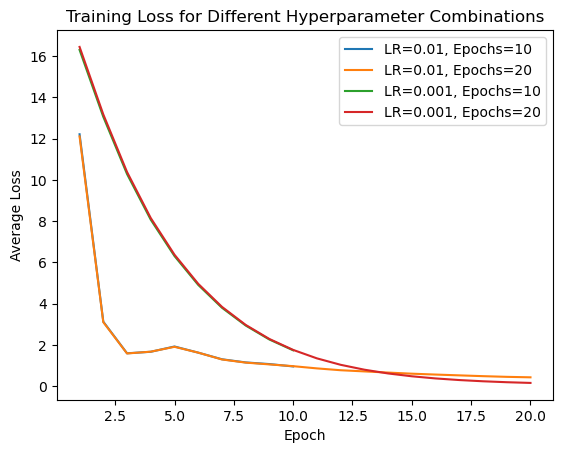


Best Model - Learning Rate: 0.001, Epochs: 20
Best Model - Best Loss: 0.1605
Final Evaluation - Accuracy: 0.1593, Recall: 0.1593, Precision: 0.9891


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [5]:
# Sample item attributes matrix (for illustration purposes)
item_attributes_matrix = torch.randn(30, 10)  # 30 items, 10 attributes

# Sample user-item interaction data (for illustration purposes)
# Replace 'your_table.csv' with the actual file name or path of your data
# Assuming the table has 'user_id', 'item_id', and 'click' columns
interactions_df = pd.read_csv('/kaggle/input/cold-data-07csv/cold_data_0.7.csv').head(200000)
interactions_df.drop_duplicates(subset=['user_id', 'item_id'], keep='first', inplace=True)

# For example, if you want to sum the 'click' values for duplicate user-item pairs
interactions_df = interactions_df.groupby(['user_id', 'item_id']).agg({'click': 'sum'}).reset_index()

# Create the interaction matrix (using 'click' as the rating proxy)
interaction_matrix = interactions_df.pivot_table(index='user_id', columns='item_id', values='click', fill_value=0)
interaction_matrix = interaction_matrix.fillna(0).values

# Create a mapping dictionary for item_ids to indices
item_id_to_index = {item_id: idx for idx, item_id in enumerate(interactions_df['item_id'].unique())}

# Set hyperparameters
num_users = interactions_df['user_id'].nunique()
num_items = interactions_df['item_id'].nunique()
num_attributes = item_attributes_matrix.shape[1]
embedding_dim = 16
learning_rate = 0.01
num_epochs = 10
batch_size = 32

# Convert user and item IDs to numerical labels using LabelEncoder
user_encoder = LabelEncoder()
interactions_df['user_id'] = user_encoder.fit_transform(interactions_df['user_id'])
item_encoder = LabelEncoder()
interactions_df['item_id'] = item_encoder.fit_transform(interactions_df['item_id'])

# Split the data into train and test sets
train_data, test_data = train_test_split(interactions_df, test_size=0.2, random_state=42)

# Filter train data to include only the item_ids present in the mapping dictionary
train_data = train_data[train_data['item_id'].isin(item_id_to_index)]

# Create DataLoader for training data
X_train_users = torch.tensor(train_data['user_id'].values, dtype=torch.long)
X_train_items = torch.tensor(train_data['item_id'].values, dtype=torch.long)

# Map the item IDs to their respective indices
X_train_indices = train_data['item_id'].map(item_id_to_index)
X_train_indices = X_train_indices.values

# Check if any indices are out of bounds for item_attributes_matrix
if (X_train_indices >= item_attributes_matrix.shape[0]).any():
    num_missing_items = (X_train_indices >= item_attributes_matrix.shape[0]).sum()
    item_attributes_matrix = torch.cat(
        [item_attributes_matrix, torch.zeros(num_missing_items, num_attributes)],
        dim=0
    )

# Indexing into item_attributes_matrix using the mapped indices
X_train_attributes = item_attributes_matrix[X_train_indices]

train_dataset = TensorDataset(X_train_users, X_train_items, X_train_attributes)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Instantiate the hybrid recommender model
class HybridRecommender(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim, num_attributes):
        super(HybridRecommender, self).__init__()
        # Matrix factorization for user and item embeddings
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.item_embedding = nn.Embedding(num_items, embedding_dim)
        # Content-based filtering module for item attributes
        self.content_module = nn.Sequential(
            nn.Linear(num_attributes, 32),  # Adjust hidden layers as needed
            nn.ReLU(),
            nn.Linear(32, embedding_dim)
        )

    def forward(self, user_ids, item_ids, item_attributes):
        # Matrix factorization embeddings
        user_embeds = self.user_embedding(user_ids)
        item_embeds = self.item_embedding(item_ids)
        # Content-based filtering embeddings
        item_content_embeds = self.content_module(item_attributes)

        # Combine matrix factorization and content-based embeddings
        user_item_interaction = torch.sum(user_embeds * item_embeds, dim=1)
        user_item_content_interaction = torch.sum(user_embeds * item_content_embeds, dim=1)

        # Hybrid recommendation score
        hybrid_score = user_item_interaction + user_item_content_interaction
        return hybrid_score

# Instantiate the hybrid recommender model
model = HybridRecommender(num_users, num_items, embedding_dim, num_attributes)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Hyperparameter tuning
learning_rates = [0.01, 0.001]
num_epochs_list = [10, 20]

# Initialize best_loss with a large value
best_loss = float('inf')
best_model = None
best_learning_rate = None
best_num_epochs = None

for lr in learning_rates:
    for epochs in num_epochs_list:
        print(f"\n===== Hyperparameters: LR={lr}, Epochs={epochs} =====")
        model = HybridRecommender(num_users, num_items, embedding_dim, num_attributes)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        losses = []

        for epoch in range(epochs):
            total_loss = 0.0
            model.train()

            for user_ids, item_ids, item_attributes in train_loader:
                optimizer.zero_grad()
                hybrid_scores = model(user_ids, item_ids, item_attributes)
                targets = torch.tensor(interaction_matrix[user_ids, item_ids], dtype=torch.float)
                loss = criterion(hybrid_scores, targets)
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

            avg_loss = total_loss / len(train_loader)
            losses.append(avg_loss)  # Store the loss value for this epoch
            print(f"Epoch {epoch+1}/{epochs}, Average Loss: {avg_loss:.4f}")

        # Check if this model has the best loss so far
        if losses[-1] < best_loss:
            best_loss = losses[-1]
            best_model = model
            best_learning_rate = lr
            best_num_epochs = epochs

        # Plot the loss values for each combination
        plt.plot(range(1, epochs + 1), losses, label=f'LR={lr}, Epochs={epochs}')

# Plot the loss values for the best model
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title(f'Training Loss for Different Hyperparameter Combinations')
plt.legend()
plt.show()

# Final evaluation using the best model
print(f"\nBest Model - Learning Rate: {best_learning_rate}, Epochs: {best_num_epochs}")
print(f"Best Model - Best Loss: {best_loss:.4f}")

# Evaluation on the test data using the best model
best_model.eval()
with torch.no_grad():
    test_scores = best_model(test_users, test_items, test_attributes)
    test_preds = torch.round(test_scores)
    accuracy = accuracy_score(test_targets, test_preds)
    recall = recall_score(test_targets, test_preds, average='weighted')
    precision = precision_score(test_targets, test_preds, average='weighted')
    print(f"Final Evaluation - Accuracy: {accuracy:.4f}, Recall: {recall:.4f}, Precision: {precision:.4f}")

**Result on Traing using Tuning Hyperparameters**

1- the best combination is when Learning Rate: 0.001, Epochs: 20

2- the best loss : 0.1605



**Result on Evaluation**

Accuracy: 0.1593

Recall: 0.1593

Precision: 0.9891